# Exercise 7

In this exercise, we are asked to compute the potential energy per particle, $\frac{U}{N}$, the pressure, $P$ and the radial distribution function $g(r)$ for a system of $N=108$ particles of Argon in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import string
import scipy.optimize 

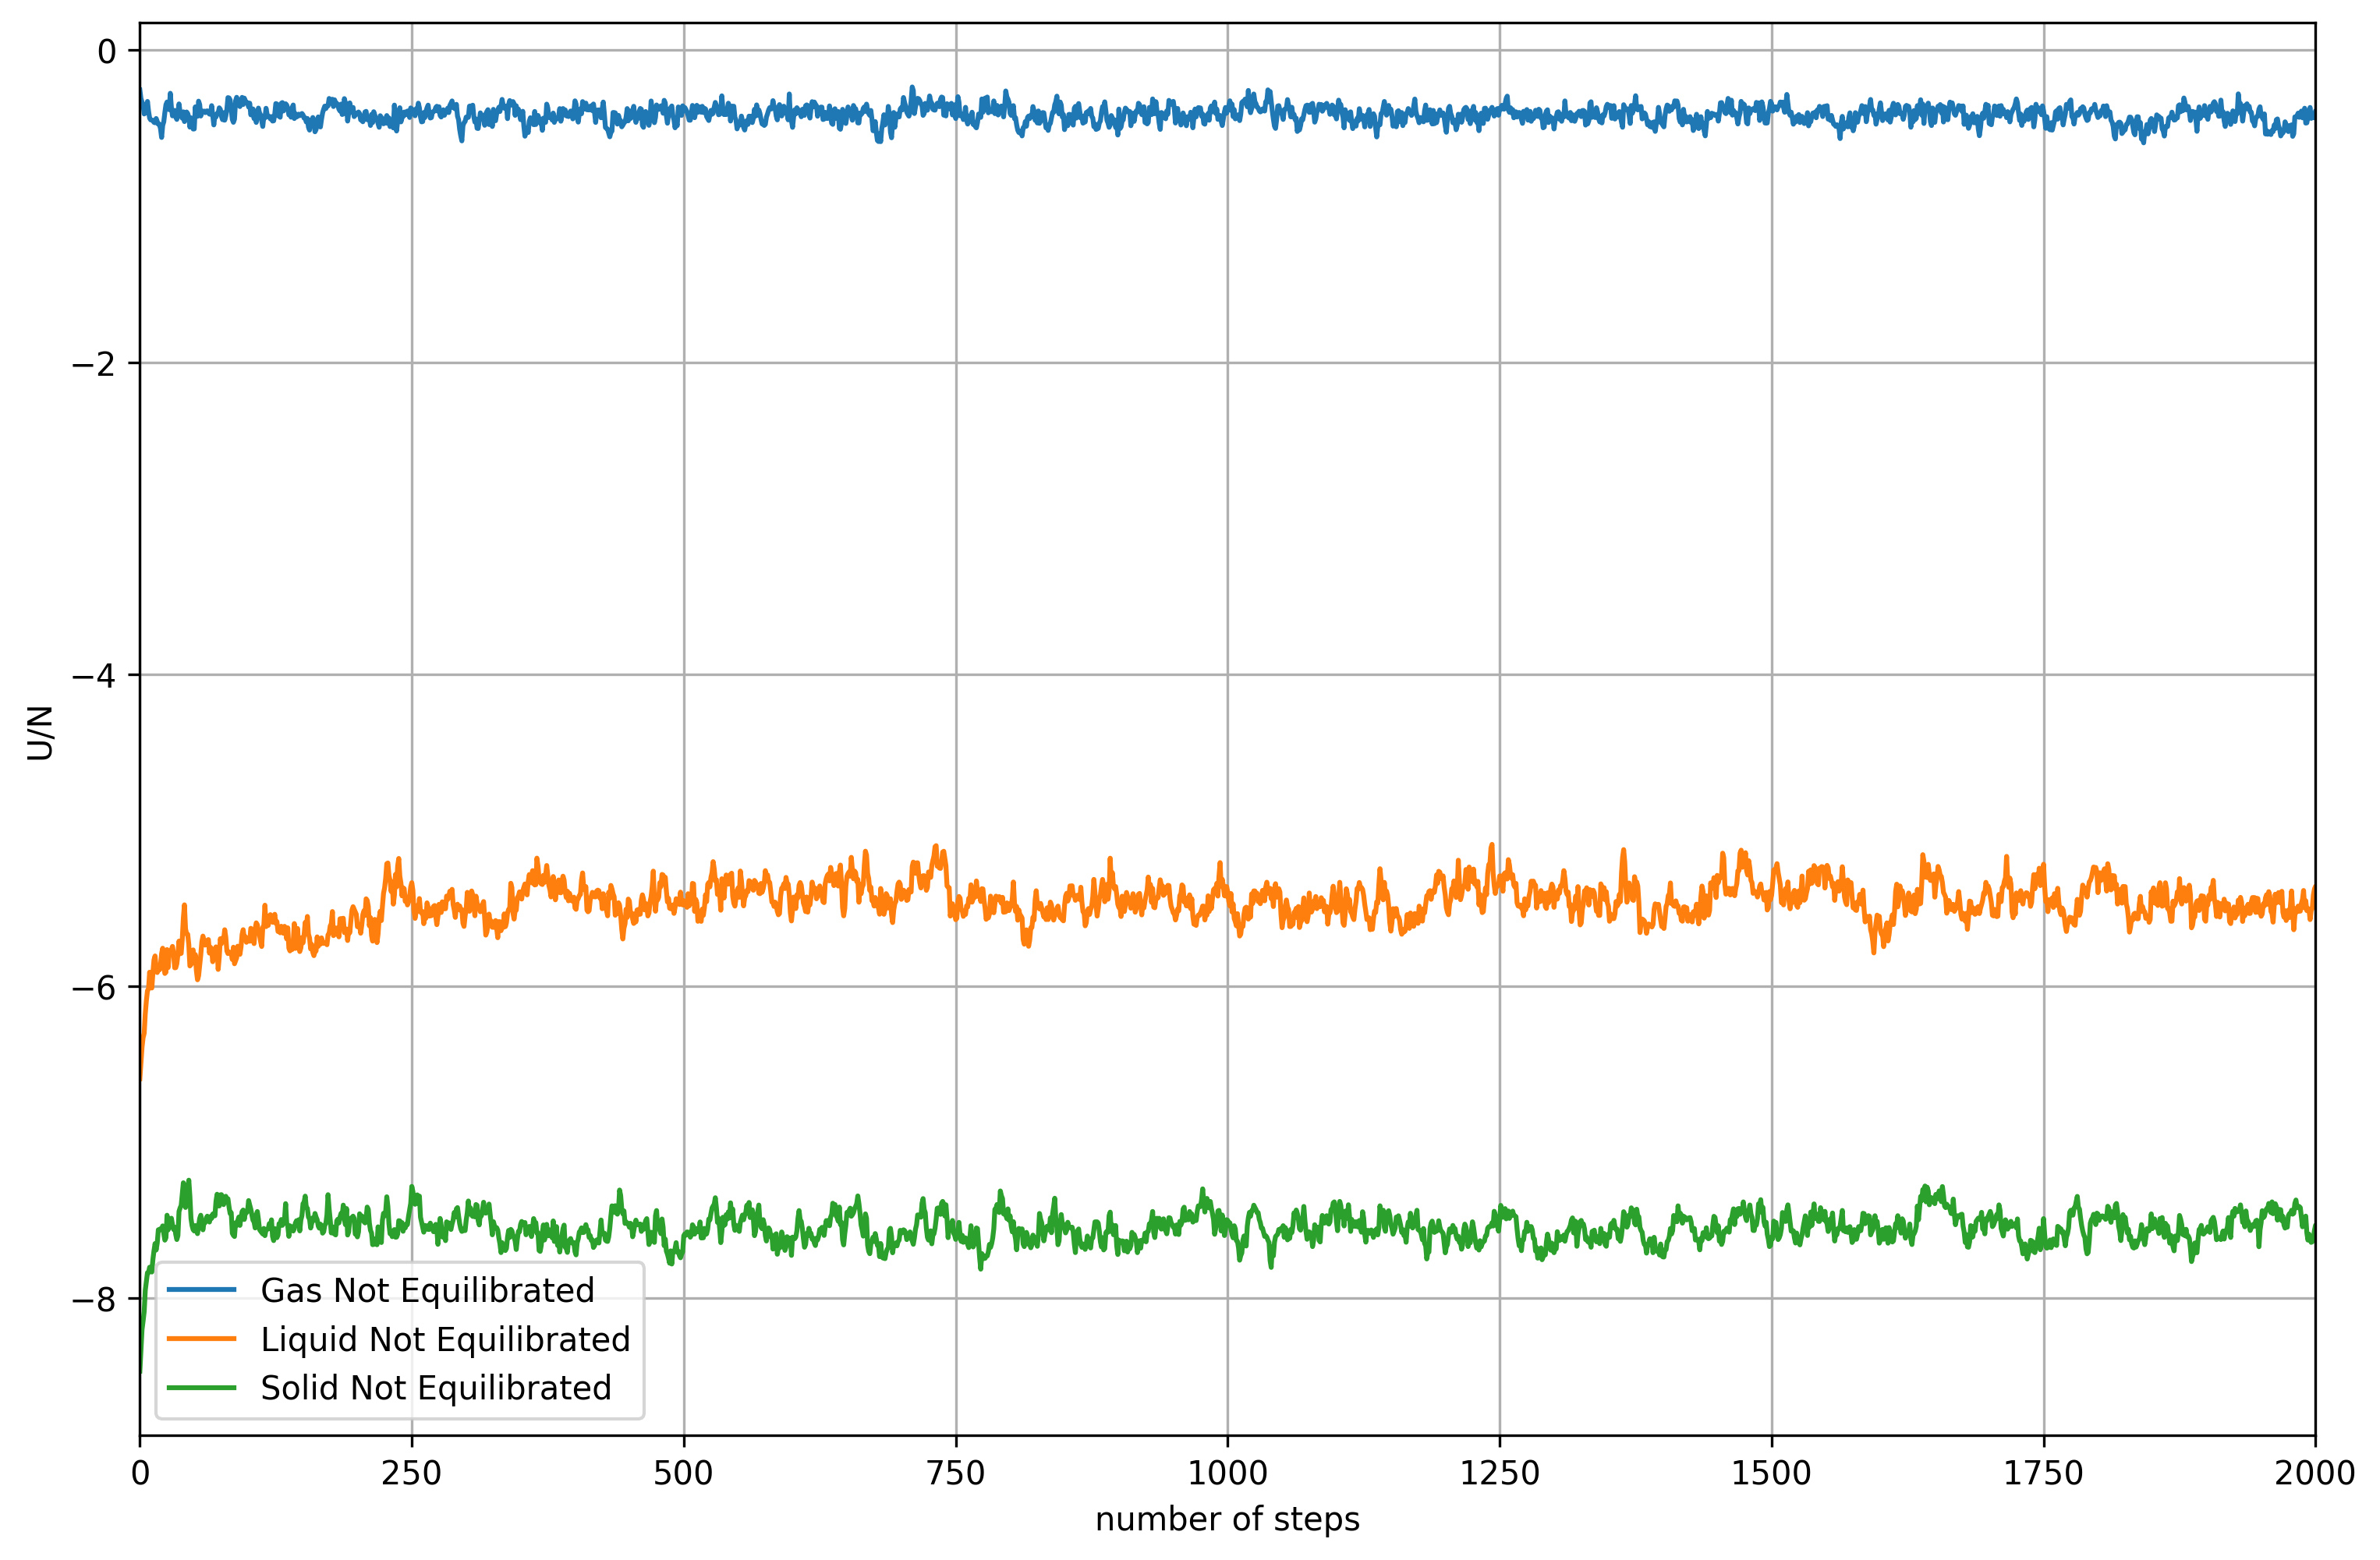

In [2]:
folder=['gasNotEq','liquidNotEq','solidNotEq']
Label=["Gas Not Equilibrated","Liquid Not Equilibrated","Solid Not Equilibrated"]
fig=plt.figure(figsize=(12,8),dpi=300)
    
for i in folder:
    
    
    x = np.loadtxt("MDNVE_MCNVT/"+i+"/InstantValues.dat", usecols=(0), delimiter=' ', unpack='true')

    plt.plot(x,label = Label[folder.index(i)])
    
plt.xlabel('number of steps')
plt.ylabel('U/N')
plt.xlim(0,2000)

plt.grid(True)
plt.legend()
plt.show()

In the previos plot, we can see that the system is equilibrated after a few steps, to be safe we set the number of equilibration steps to $500$ for all phases. In the simulations, at each step we select $N$ times a random particle and propose a change in its position with a uniform transition probability:
$$\vec{x}_{new}=\vec{x}_{old}+\delta\cdot \vec{r}$$
where $r$ components are random numbers in $[0,1]$.
The parameter $\delta$ has been tuned in order to have a $50\%$ acceptance rate for liquid and solid phases ($\delta_{solid}=0.12$ and $\delta_{liquid}=0.2$).
Because of the periodic boundary conditions, for the gas phase is not possible to have an acceptance rate lower than $\sim 62\%$, which is achieved for $\delta=\frac{l}{2}$, where $l$ is the lenght of the simulation box(we used $\delta_{gas}=5.5$, which is a little less than $\frac{l}{2}\simeq 6.46$).

# Autocorrelation functions

With the values of $\frac{U}{N}$ at each step, obtained from the simulations, we can calculate the *autocorrelation function*:
$$\chi(\tau)= \frac{\frac{1}{t-\tau}\sum_{t' = 0}^{t-\tau}x(t')x(t'+\tau)-\frac{1}{t-\tau}\sum_{t' = 0}^{t-\tau}x(t')\times \frac{1}{t-\tau}\sum_{t' = 0}^{t-\tau}x(t'+\tau)}{\frac{1}{t}\sum_{t' = 0}^{t}x^2(t')-\left(\frac{1}{t}\sum_{t' = 0}^{t}x(t')\right)^2} \, ,$$



To estimate the correlation time $t_c$ we fit $\chi(\tau)$ with the function $e^{-\frac{\tau}{t_c}}$.

In [3]:


def autocorrelation(array,lag):
    n = len(array)
    sum1 = 0.0
    sumt=0.0
    sumlag=0.0
    
    for i in range(n-lag):
        sum1 += array[i]*array[i+lag]
        sumt+=array[i]
        sumlag+=array[i+lag]
    
    sum1/=(n-lag)
    sumt/=(n-lag)
    sumlag/=(n-lag)
    
    sumsquared=0.0
    mean=0.0
    
    for k in range(n):
        sumsquared+=array[k]*array[k]
        mean+=array[k]
    
    sumsquared/=n
    mean/=n
    
    return (sum1-sumt*sumlag)/(sumsquared-mean*mean)


In [4]:
folder=['gas','liquid','solid']
Titles=["U/N autocorrelation for gas phase","U/N autocorrelation for liquid phase","U/N autocorrelation for solid phase"]

def f(t,tc):  # defining the fitting function
    return np.exp(-(t/tc)) 

fig=plt.figure(figsize=(15,25),dpi=300)
for i in folder:
    x  = np.loadtxt("MDNVE_MCNVT/"+i+"/InstantValues.dat", usecols=(0), delimiter=' ', unpack='true')
    plt.subplot(3,1,folder.index(i)+1)
    
    maxlag=150
    autocorrelation_epot=[autocorrelation(x,lag) for lag in range(maxlag)]
    plt.plot(autocorrelation_epot, label='measures',marker="o",linestyle="None")
    
    p0=1.0

    popt,pcov= scipy.optimize.curve_fit(f,range(maxlag),autocorrelation_epot,p0)
    perr= np.sqrt(np.diag(pcov))
    print("correlation time of U/N for "+i+" phase = ",popt[0])
    
    plt.plot(f(range(maxlag),*popt) , color="red",label="fit")
    plt.xlabel('lag')
    plt.ylabel('autocorrelation')
    plt.title(Titles[folder.index(i)],weight="bold",size=14)
    plt.grid(True)
    plt.legend()

plt.show()

correlation time of U/N for gas phase =  2.5696251714453706
correlation time of U/N for liquid phase =  9.452427478005935
correlation time of U/N for solid phase =  8.146630809795615


Then, to have uncorrelated blocks in the *Data Blocking* method we take a number of steps in each block ($L$)  greater than $2\cdot t_c$
- gas phase: $t_c=2.57$;
- liquid phase: $t_c=9.45$;
- solid phase: $t_c=8.15$.

# Statistical uncertainties

We apply the *Data Blocking* method on the $\frac{U}{N}$ data set, for $L$ that changes from $10$ to $5000$.

In [5]:
def DataBlockingError(array,L):
    M=len(array)
    N=int(M/L)
    ave=0
    av2=0
    
    for i in range(N):
        sum1=0
        for j in range(L):
            k=j+i*L
            sum1+=array[k]
        sum1/=L
        ave += sum1
        av2 += sum1**2
    ave/=N
    av2/=N
    
    return np.sqrt((av2-(ave)**2)/N)
    

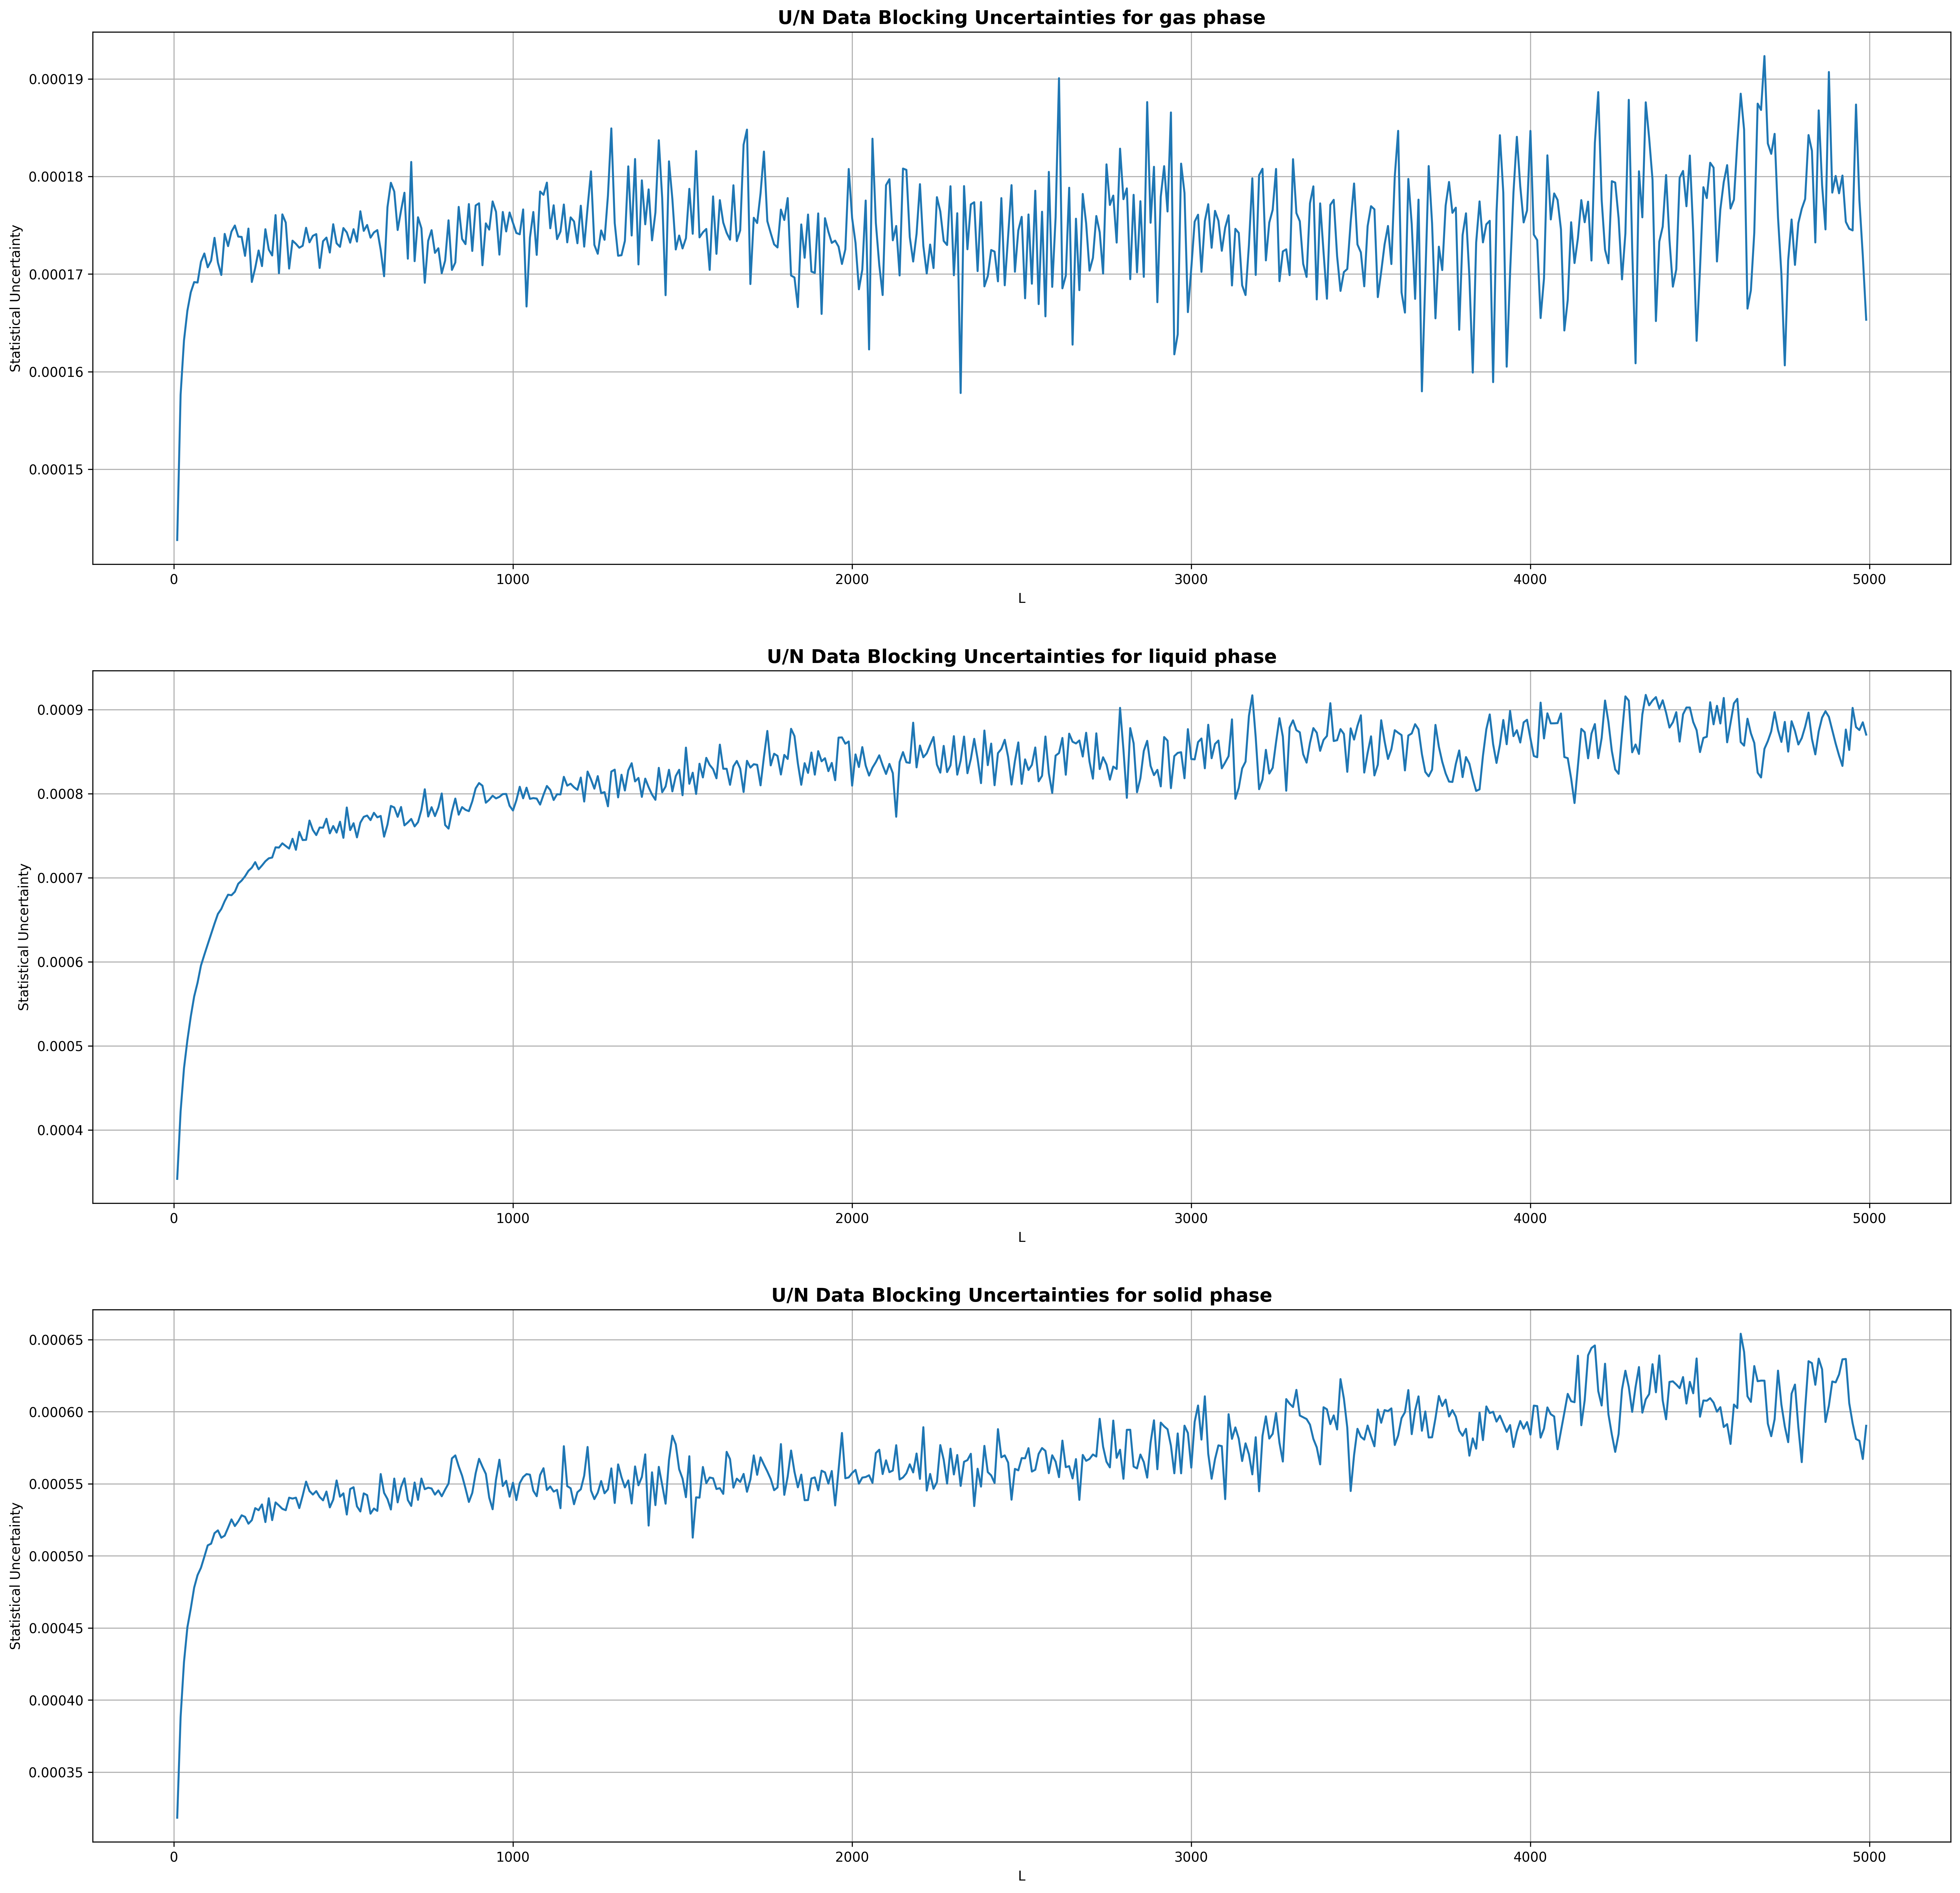

In [6]:
folder=['gas','liquid','solid']
Titles=["U/N Data Blocking Uncertainties for gas phase","U/N Data Blocking Uncertainties for liquid phase","U/N Data Blocking Uncertainties for solid phase"]

fig=plt.figure(figsize=(25,25),dpi=300)
for i in folder:
    plt.subplot(3,1,folder.index(i)+1)
    u = np.loadtxt("MDNVE_MCNVT/"+i+"/InstantValues.dat", usecols=(0), delimiter=' ', unpack='true')
    
    
    error_epot=[DataBlockingError(u,L) for L in range(10,5000,10)]
    plt.plot(range(10,5000,10),error_epot)
    plt.xlabel('L')
    plt.ylabel('Statistical Uncertainty')
    plt.title(Titles[folder.index(i)],weight="bold",size=14)
    plt.grid(True)
    #plt.legend()
plt.show()
    
    

In the previous plots:
- for small values of $L$ the statistical uncertainty increases steadily. This corresponds to different blocks being correlated.
- Then the uncertainty saturates and this means that the blocks are uncorrelated. In this region the conditions for the Central Limit Theorem are verified.
- For high values of $L$, the statistical uncertainty increases. This is caused by the decrease of the number of blocks, which correspondes to a fewer number of uncorrelated measures.

# Plots

Using the previous results, we apply the *Data Blocking* method with $L=1000$ and $J=500$ number of blocks. For all phases, $L$ is in the saturation region and is greater than $t_c$.
For Molecular Dynamics NVE simulations we used the parameters found in the exercise 4.


------------------------------------------------------------------

<p> for J=500:  0.049042  +-  1.51161e-05
<U/N> for J=500:  -0.414226  +-  0.000175246



-----------------------------------------------------------------

<p> for J=500:  1.39858  +-  0.00399021
<U/N> for J=500:  -5.46375  +-  0.000779928



-----------------------------------------------------------------

<p> for J=500:  7.59445  +-  0.00302318
<U/N> for J=500:  -7.54642  +-  0.000550731


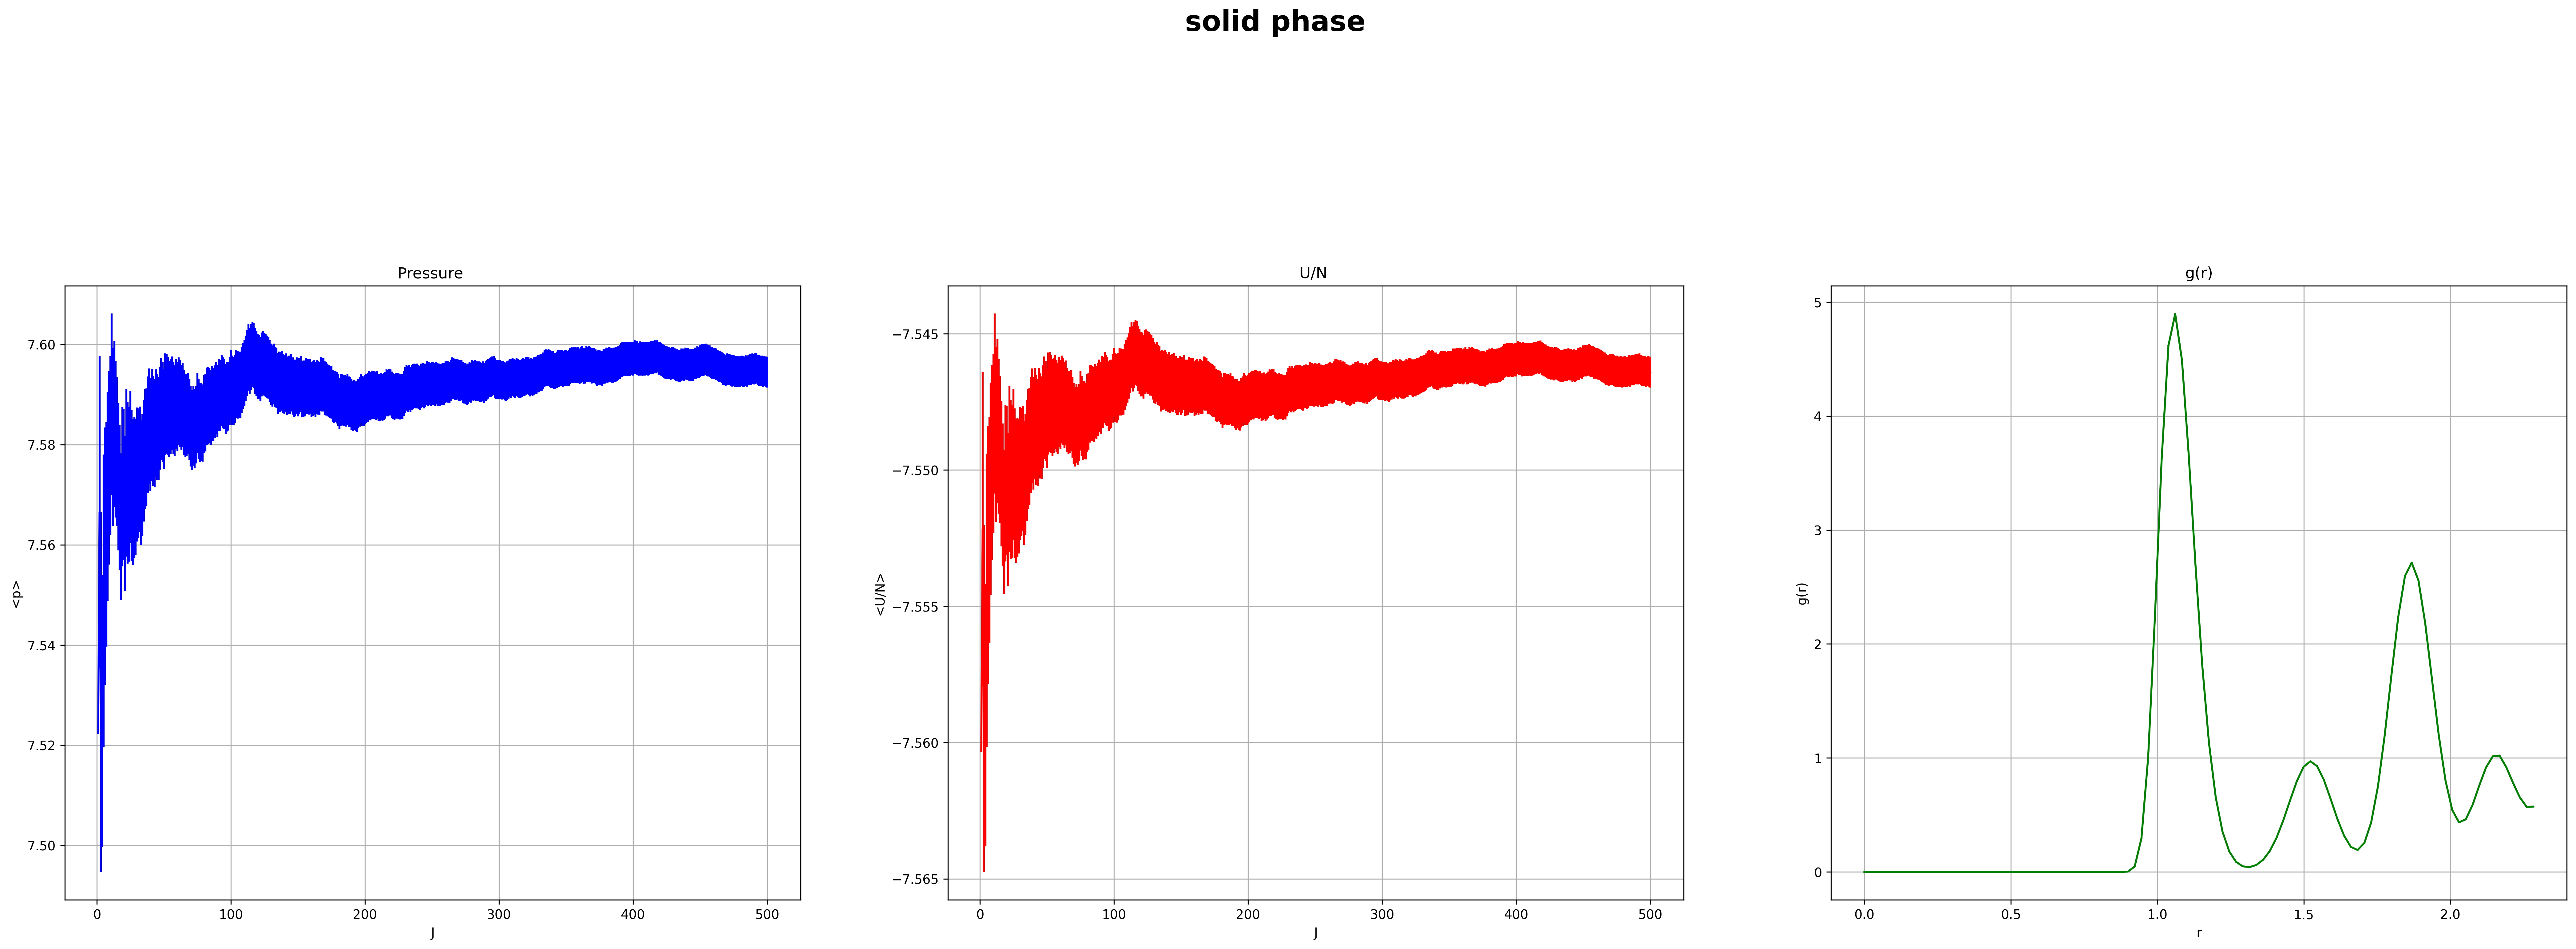


-----------------------------------------------------------------



In [15]:
folder=["gas","liquid","solid"]
folder2=['gasNVE','liquidNVE','solidNVE']
file=["/output_press.dat","/output_epot.dat","/output_gave.dat"]
Labels=['<p>','<U/N>',"g(r)"]
Titles=["Pressure ","U/N ","g(r)"]
x_axes=["J","J","r"]
Colors=["blue","red","green"]
print('\n------------------------------------------------------------------\n')
for i in folder:
    fig=plt.figure(figsize=(35,30),dpi=300)
    plt.suptitle(i+" phase\n", weight="bold",size="22")
    for j in file:
        
        plt.subplot(3,3,file.index(j)+1)
        x , y, f, error = np.loadtxt("MDNVE_MCNVT/"+i+j, usecols=(0,1,2,3), delimiter=' ', unpack='true')
        
        plt.errorbar(x,f,yerr=error,color=Colors[file.index(j)])
        plt.xlabel(x_axes[file.index(j)])
        plt.ylabel(Labels[file.index(j)])
        plt.grid(True)
        if j!=file[2]:
            print(Labels[file.index(j)]+" for J=500: ",f[-1] ," +- ", error[-1])
        
        plt.title(Titles[file.index(j)])
    plt.show()
    print("\n-----------------------------------------------------------------\n")

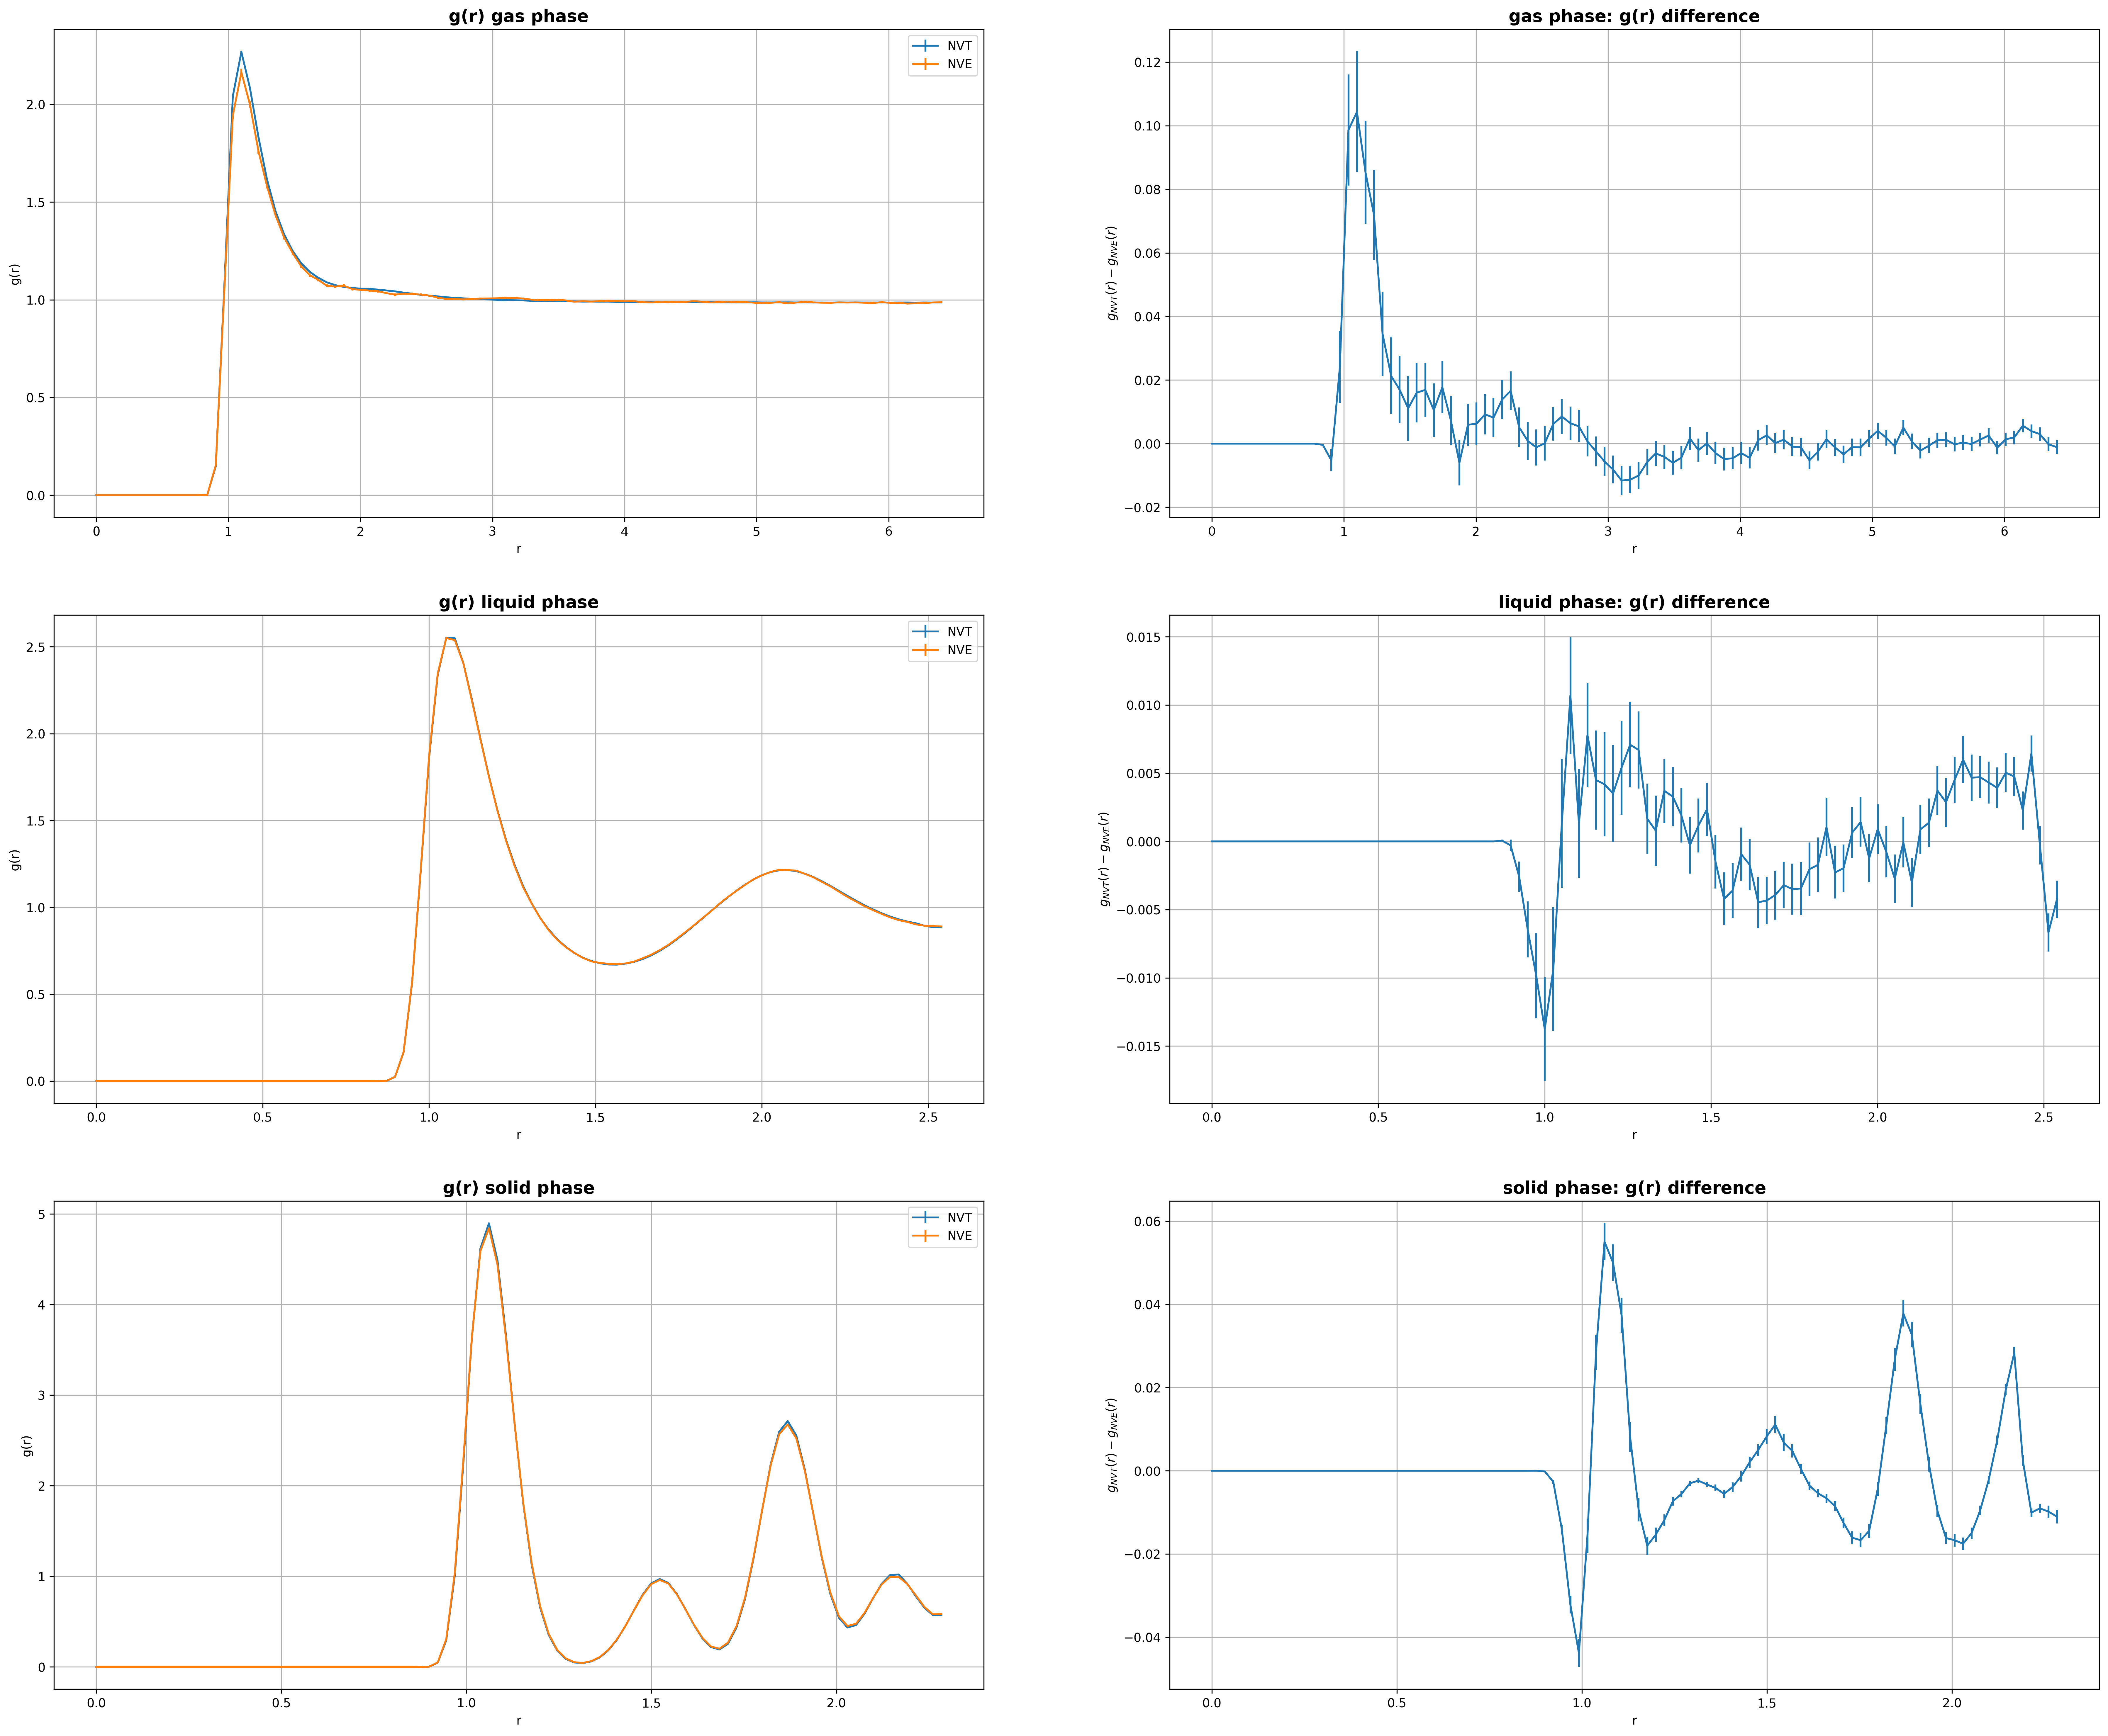

In [21]:
folder=['gas','liquid','solid']
folder2=['gasNVE','liquidNVE','solidNVE']
Titles=["g(r) gas phase","g(r) liquid phase","g(r) solid phase"]
fig=plt.figure(figsize=(30,25),dpi=300)
for i in folder:  
    plt.subplot(3,2,2*folder.index(i)+1)
    x , y, f, error = np.loadtxt("MDNVE_MCNVT/"+i+"/output_gave.dat", usecols=(0,1,2,3), delimiter=' ', unpack='true') 
    plt.title(Titles[folder.index(i)],weight="bold",size=14)
    plt.errorbar(x,f,yerr=error,label = "NVT")
    x_N , y_N, f_N, error_N = np.loadtxt("MDNVE_MCNVT/"+i+"NVE/output_gave.dat", usecols=(0,1,2,3), delimiter=' ', unpack='true')
    plt.errorbar(x,f_N,yerr=error_N,label = "NVE")
    plt.legend()
    plt.xlabel('r')
    plt.ylabel('g(r)')
    plt.grid(True)
    plt.subplot(3,2,2*folder.index(i)+2)
    plt.errorbar(x,f-f_N,np.sqrt(error**2+error_N**2))
    plt.title(folder[folder.index(i)]+" phase: g(r) difference",weight="bold",size=14)
    plt.xlabel('r')
    plt.ylabel('$g_{NVT}(r)-g_{NVE}(r)$')
    plt.grid(True)
plt.show()

In all cases the radial distribution functions for the two algorithms have the same behaviour.